# GATK 전 파일 변환 방식 

* https://gatk.broadinstitute.org/hc/en-us/articles/360039568932#step3D

* linux or MacOS에서 구동이 가능 
* Java 8 / JDK 1.8 의 설치가 필요
* gatk의 패키지를 설치한 후 실행
* calling을 직접하기 보다는 gatk의 alias를 설정하여 진행하기
* 또는 export PATH="/path/to/gatk-package/:$PATH를 설정하여서 바로 gatk wrapper script시행
* gatk [--java-options "jvm args like -Xmx4G go here"] ToolName [GATK args go here]의 식으로 진행
* gatk --java-options "-Xmx8G" HaplotypeCaller -R reference.fasta -I input.bam -O output.vcf


1. set up environment and tools
2. create index, dictionary file, ref fasta file
3. un-mapped BAM
4. un-mapped BAM -> uBAM
5. convert the BAM file to FASTq
6. merge bam alingnment -> add information to BAM file [BWA]
7. Mark duplicate and sorting [picard]

## set up environment and tools

* 필요한 프로그램 환경을 최적화 하기 위하여 conda환경에서 시행하는 것이 좋음
* gatk 
* samtools
* bwa
* picard

## 0. reference gene 설정
* mapping 할 reference genome을 설정함
* amb, ann, bwt, pac and sa의 파일이 형성

In [ ]:
samtools faidx human_g1k_v37.fasta
gatk CreateSequenceDictionary -R human_g1k_v37.fasta
bwa index -a bwtsw human_g1k_v37.fasta #5개의 파일이 생성되어짐

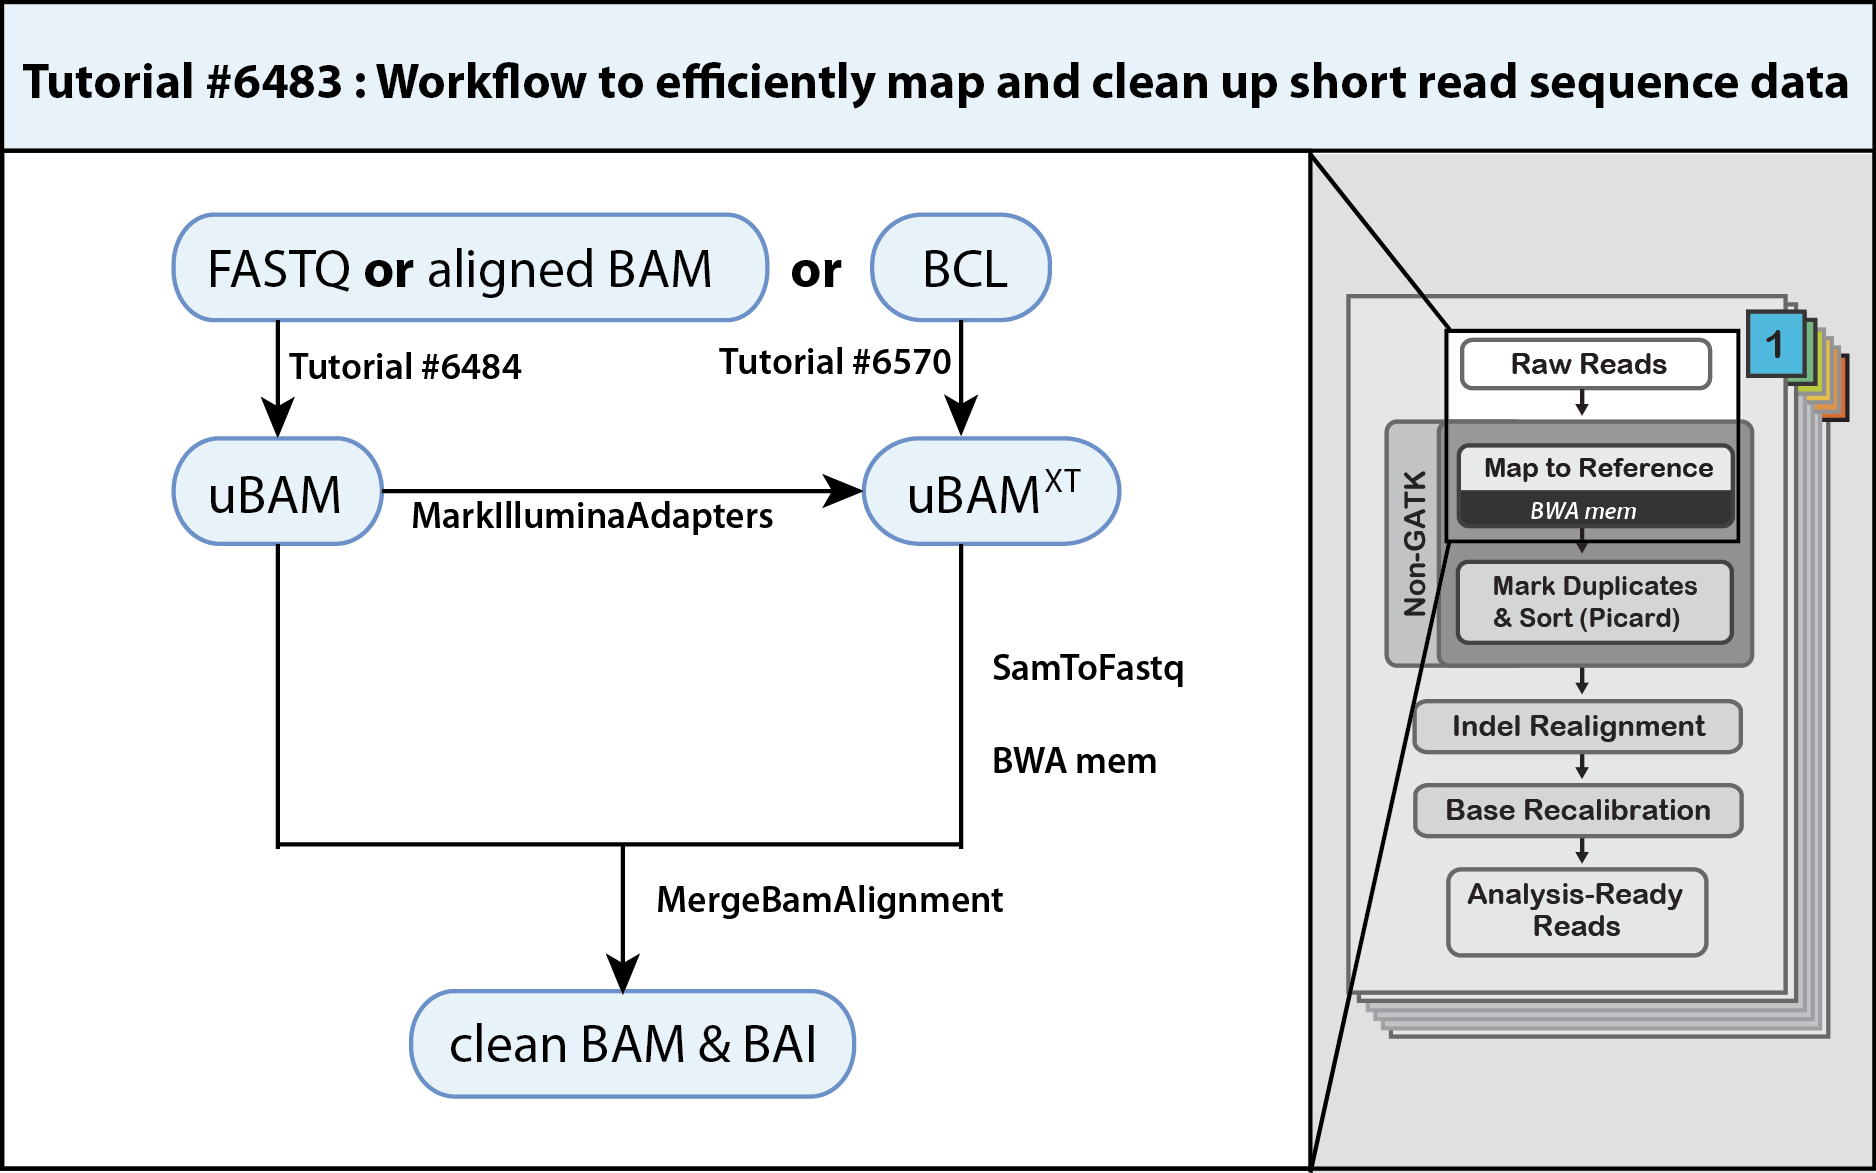

In [5]:
Image("./workflow to efficiently map and clean up shor reads.png")

## Data pre -processing for variants discovery

* variants discovery에 있어 가장 먼저 해야 하라 단계
* 모든 BAM 파일이 동일하지 않아서 meta information을 cleaning up 해야 함
* pre-processing the raw sequence (FASTQ or uBAM)을 BAM 파일로 변환

### 1. Generate a compatible  unmapped BAM
* uBAM file은 read data가 mapping information을 가지고 있지 않은 것
* metatdataf를 보존하기 위하여 형성한다.
* 추후 bwa를 시행 할 시 fastq파일은 metadata를 가지고 있지 않아서 uBAM으로 합병
* meta-data란 seq당시의 sample, 기기등을 의미, quality score
##### 1. FastqToSam
* fastq 파일을 SAM파일로의 변환을 해주는 기능
##### 2.  AddOrReplaceReadGroups
* 모든 reads들을 한개의 single new read group에 할당을 시행(read group 통합)
* input으로 sam, bam 파일을 집어 넣음
* 사용하면서 sample에 RG(read groups 정보를 제공함)

In [ ]:
java -jar picard.jar FastqToSam \
F1 = file_1.fastq \
O = fastq_to_bam.bam \
SM = HG00096

In [ ]:
java -jar picard.jar AddOrReplaceReadGroups \
I=HG_fastq_to_bam.bam \
O=HG_unmapped.bam \
RGID=4 \   #read group ID
RGLB=lib1 \ #read group library
RGPL=ILLUMINA \ #read group platform
RGPU=unit1 \ #read group platform unit(run barcode)
RGSM=20 #read group sample name(동일한 sample에서 시행해서 중요)
#https://gatk.broadinstitute.org/hc/en-us/articles/360035890671-Read-groups

#### 1_2 BCL file일 경우  IlluminaBasecallsToSam를 사용
http://broadinstitute.github.io/picard/command-line-overview.html#IlluminaBasecallsToSam
* 이미 XT tag가 존재하여 3번으로 바로 진행 가능

In [ ]:
java -jar picard.jar IlluminaBasecallsToSam \
      BASECALLS_DIR=/BaseCalls/ \
      LANE=001 \
      READ_STRUCTURE=25T8B25T \
      RUN_BARCODE=run15 \
      IGNORE_UNEXPECTED_BARCODES=true \
      LIBRARY_PARAMS=library.params 

#### 1_3만약 이미 aligned 되어진 bam파일이 존재할 시 unmappping을 다시 시행[RevertSam]

In [ ]:
java -Xmx8G -jar picard.jar RevertSam \
I=HG00096.chrom20.ILLUMINA.bwa.GBR.exome.20120522.bam \
O=HG_rev.bam \
SANITIZE=true \
ATTRIBUTE_TO_CLEAR=XT \
ATTRIBUTE_TO_CLEAR=XN \
ATTRIBUTE_TO_CLEAR=AS \
ATTRIBUTE_TO_CLEAR=OC \
ATTRIBUTE_TO_CLEAR=OP \

### 2. Sequence에 adapter을 부착
#### MarkilluminaAdapter사용
* MarkilluminaAdapter는 SAM, BAM파일을 읽어 새로운 adapter-trimming tag생성을 함
* existing adapter-trimming tags (XT:i:)을 제거하며 파일들을 query name으로 정렬을 시킴
* 그냥 fastq 파일을 생성하기 위해 붙여 주었던 meta data를 없앤다고 생각

In [ ]:
java -Xmx8G -jar picard.jar MarkIlluminaAdapters \
I=HG_unmapped.bam \
O=HG_adapter.bam \
M=HG_adapter.metrics.txt \ # 얼마나 많은 read들이 base_clip에 필요했는지 히스토그램
TMP_DIR=/path/shlee #optional to process large files

In [ ]:
# check with sammtools view를 이용하여 잘 되었는지 확인
samtools view HG_adapter.bam |grep 'XT:i:'

### 3. clean Bam
* Piping SamToFastq, BWA-MEM and MergeBamAlignment과정으로 구성
#### SamToFastq
* read sequences, idenrifiers, base quality score을 통해 fastq 생성
* 기존에 존재하는 XT tag를 제거를 해줌 이를 이용해 phred scale을 형성
#### BWA-MEM
* 가장 시간이 많이 걸리는 과정
* decoy genome을 이용하여 mapping 을 진행(EBV)은 연구에 있어서는 노노
#### MergeBamAlignment
* MergeBamAlignment이용 하여 SAM파일을 uBAM과 합쳐서 메타 정보를 통일화 함
* 많은 기능이 존재 하며 aligner로부터 생성되어진 aligner-generated designations, mate information, ssecondart alignment flag 생성
* https://gatk.broadinstitute.org/hc/en-us/articles/360039568932

In [ ]:
java -Xmx8G -jar picard.jar SamToFastq  #samToFastq 사용
I=HG_adapter.bam 
FASTQ=HG_input.fq 
CLIPPING_ATTRIBUTE=XT # 기존에 존재하는 adapter의 종류
CLIPPING_ACTION=2 
INTERLEAVE=true  #pair관계에 있는 read들은 /1 /2로 표시 
NON_PF=true # 이것들은 잘 모르겠음...
# https://gatk.broadinstitute.org/hc/en-us/articles/360039568932

In [ ]:
bwa index -a bwtsw human_g1k_v37.fasta #reference genome의 인덱스로 설정
bwa mem -M -t 7 -p human_g1k_v37.fasta  #BWA 사용
HG_input.fq  > HG_aligned.sam #파일을 오른쪽 파일로 변환을 시행

In [ ]:
java -Xmx16G -jar picard.jar MergeBamAlignment R=human_g1k_v37.fasta 
UNMAPPED=HG_unmapped.bam 
ALIGNED=HG_aligned.sam  
O=HG_preprocessed.bam 
CREATE_INDEX=true  ##standard Picard option for coordinate-sorted outputs
ADD_MATE_CIGAR=true  # MC tag를 더해줌
CLIP_ADAPTERS=false # read로부터 adapter을 clip할것인지
CLIP_OVERLAPPING_READS=true  
INCLUDE_SECONDARY_ALIGNMENTS=true  
MAX_INSERTIONS_OR_DELETIONS=-1  
PRIMARY_ALIGNMENT_STRATEGY=MostDistant 
ATTRIBUTES_TO_RETAIN=XS 

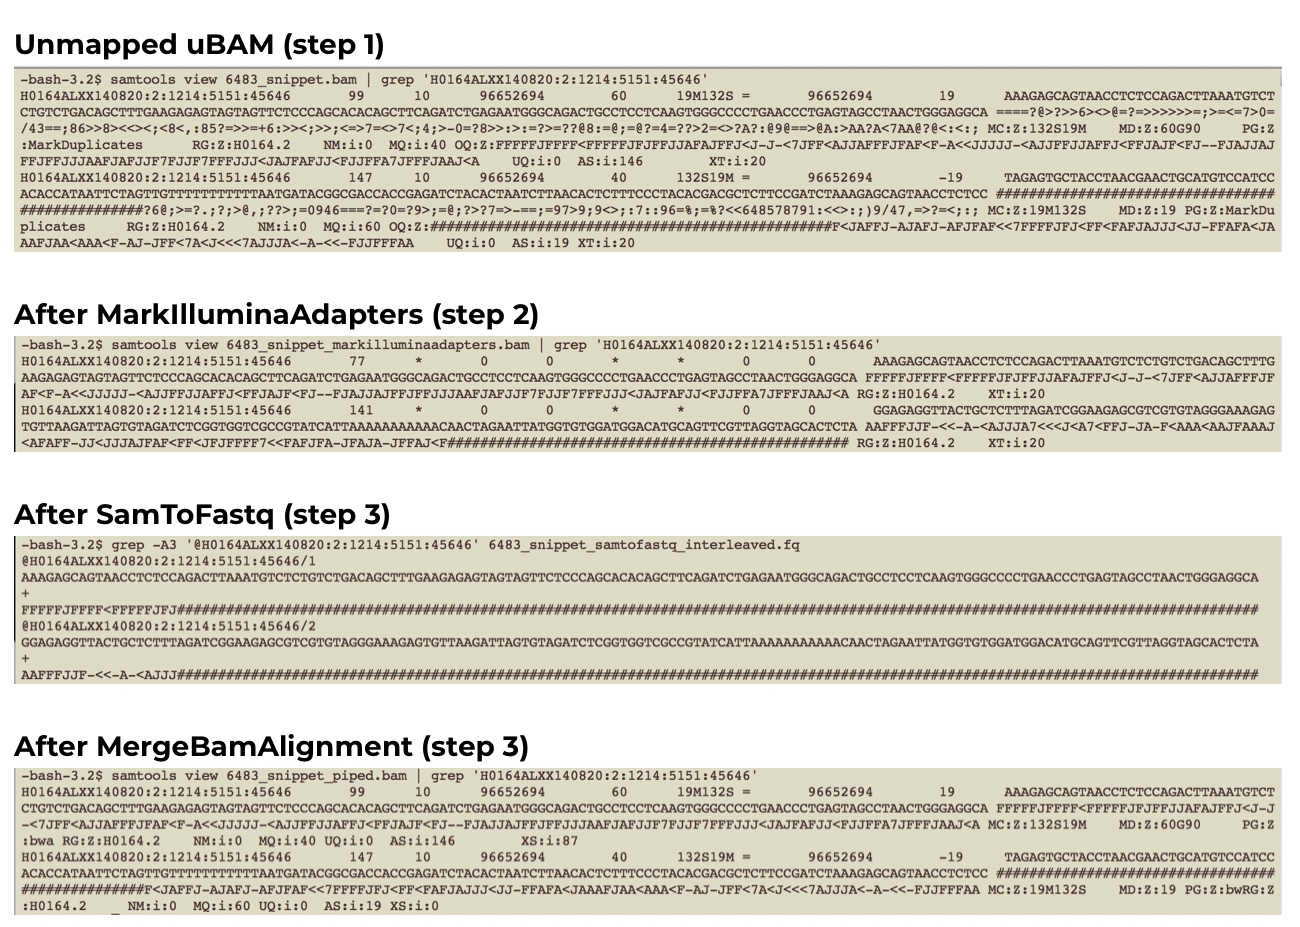

In [5]:
Image("./seq.png")

### 4. Mark duplicated reads and sort
* 5' position을 비교하여서 중복되어진 서열을 찾음
* 알고리즘을 통하여(base-quality socre sum)중복서열을 flag를 생성함
* flag 란 서열을 알려주는 일종의 2진수로 나타내어진 것
* https://github.com/broadinstitute/gatk-docs/blob/master/blog-2012-to-2019/2016-02-18-Sam_flags_down_a_boat.md?id=7019 flag 정보


In [ ]:
java -jar picard.jar MarkDuplicates 
I=HG_preprocessed.bam 
O=HG_dedup.bam 
M=HG_dedup.metrics.txt

In [ ]:
java -jar picard.jar SortSam # 정확도를 높이기 위해 한번 더 돌림 
I=HG_dedup.bam 
O=HG_sorted.bam 
SO=coordinate 

### 5. Base quality score recalibration
* machine learning 방법을 사용하여 시행
* base call data로부터 covariate를 합산하여 statistics model을 생성
* per region statistcswh tlgodehldjwlau dufj qkdqjqemfdl whswo
* 기존에 잘 알려진 정보로부터도 시행
* 총 2가지 방법으로 진행이 되어짐 

In [ ]:
gatk --java-options '-Xmx16g' BaseRecalibrator 
-I HG_sorted.bam 
-R human_g1k_v37.fasta 
--known-sites ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf.gz
# 한개이상의 알려진 polymorphism analysis의 자료 알려진것들과 비교하려고 사용하는 듯
# -XL my.interval.list 로 설정이 가능 함
-O HG.recal_data.table #이게 설정이 되어지면

In [ ]:
gatk --java-options '-Xmx16g' ApplyBQSR
-I HG_sorted.bam 
-R human_g1k_v37.fasta
--bqsr-recal-file HG.recal_data.table #생성되어진 테이블을 사용하여  시행
-O HG.fin.bam    #모두 완료되어진 bam file 형성
# https://gatk.broadinstitute.org/hc/en-us/articles/360056968652-ApplyBQSR